In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Rationale

For some certain loss functions, such the the negative evidence lower bound (NELBO) in variational inference, they are generally analytically intractable and thus unavailable in closed-form. As such, we might need to resort to taking stochastic estimates of the loss function. In these situations, it is very important to study and understand the robustness of the estimations we are making, particularly in terms of bias and variance. When proposing a new estimator, we may be interested in evaluating the loss at a fined-grained level - not only per batch, but perhaps even per data-point. 

This notebook explores storing the recorded losses in Pandas Dataframes. The recorded losses are 3d, with dimensions corresponding to epochs, batches, and data-points. Specifically, they are of shape `(n_epochs, n_batches, batch_size)`. Instead of using the deprecated Panel functionality from Pandas, we explore the preferred MultiIndex Dataframe.

Lastly, we play around with various data serialization formats supported out-of-the-box by Pandas. This might be useful if the training is GPU-intensive, so the script runs and records the loss remotely on a supercomputer, and we must write the results to file, download them and finally analyze them locally. This is usually trivial, but it is unclear what the behaviour is for more complex MultiIndex dataframes. We restrict our attention to the CSV format, which is human-friendly but very slow and inefficient, and the HDF5, which is basically diametrically opposed - it's basically completely inscrutable, but is very fast and takes up laess space.

### Synthetic Data

In [3]:
# create some noise
a = np.random.randn(50, 600, 100)
a.shape

(50, 600, 100)

In [4]:
# create some noise with higher variance and add bias.
b = 2. * np.random.randn(*a.shape) + 1.
b.shape

(50, 600, 100)

In [5]:
# manufacture some loss function
# there are n_epochs * n_batchs * batch_size 
# recorded values of the loss
loss = 10 / np.linspace(1, 100, a.size)
loss.shape

(3000000,)

### MultiIndex Dataframe

In [6]:
# we will create the indices from the 
# product of these iterators
list(map(range, a.shape))

[range(0, 50), range(0, 600), range(0, 100)]

In [7]:
# create the MultiIndex
index = pd.MultiIndex.from_product(
    list(map(range, a.shape)), 
    names=['epoch', 'batch', 'datapoint']
)

In [8]:
# create the dataframe that records the two losses
df = pd.DataFrame(
    dict(loss1=loss+np.ravel(a), 
         loss2=loss+np.ravel(b)), 
    index=index
)
df

loss1      loss2
epoch batch datapoint                      
0     0     0          10.837250  10.228649
            1           9.383650   9.601012
            2           9.102928  12.792865
            3           9.149701  11.307185
            4           9.181607   9.905578
            5           8.984361  11.646015
            6           8.935352  10.793933
            7           9.273609   9.421425
            8          10.846009   9.916008
            9          10.288851   7.250876
            10         10.360709  10.911360
            11          9.514765   7.339939
            12          9.922280  10.494360
            13          9.094041  13.302492
            14          9.693384  12.187093
            15          9.675839  13.418631
            16         11.502391   9.470244
            17         10.958843  12.709454
            18         10.819225  11.700684
            19          9.412562  10.272870
            20         10.424428  10.477799
            21          9.009290  13.920663
            22          8.127529  13.179637
            23          8.939673  13.091603
            24          8.064599   7.311483
            25          9.924553  15.597797
            26          8.572734  14.338683
            27         10.294223   7.761236
            28         11.191123   8.993673
            29          9.424269  12.067344
...                          ...        ...
49    599   70          1.975951   2.746047
            71          1.169242   4.194400
            72          0.248216   0.730370
            73         -0.271330   0.415903
            74         -0.888580   0.208060
            75         -0.624063   1.081515
            76         -1.422904   0.398015
            77          0.332523   1.892470
            78         -0.224471  -2.839332
            79          0.405337   0.266035
            80          0.223712   5.810484
            81         -0.508689   7.535930
            82         -1.915472  -0.275332
            83         -0.597498   2.799929
            84         -0.443378   2.202897
            85          0.610826   1.825950
            86          0.305465   0.757416
            87         -1.139339   3.221787
            88         -1.893639   0.520711
            89         -0.286300   3.112420
            90          1.268100   1.341298
            91          0.251563   1.040859
            92          0.083156   1.311108
            93         -0.554107   8.272526
            94         -2.415105   2.607663
            95          0.335266   2.038404
            96          0.554412   2.200551
            97          0.392182   1.444542
            98         -0.252059   1.641488
            99         -0.070091   1.490349

[3000000 rows x 2 columns]

### Visualization

In this contrived scenario, `loss2` is more biased and has higher variance.

<IPython.core.display.Javascript object>


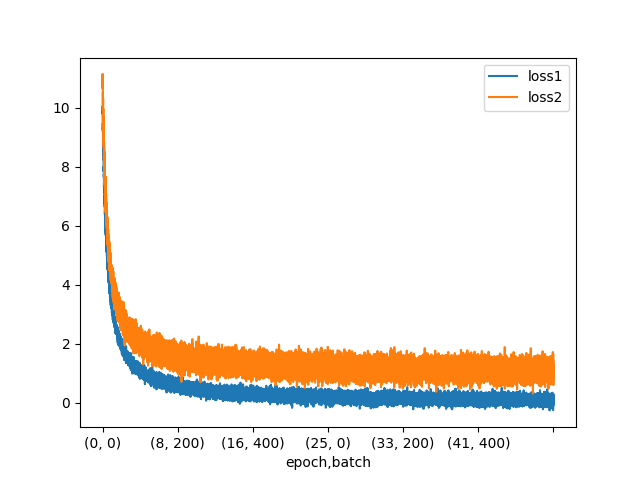

In [9]:
# some basic plotting
fig, ax = plt.subplots()

df.groupby(['epoch', 'batch']).mean().plot(ax=ax)

plt.show()

### CSV Read/Write

In [10]:
%%time

df.to_csv('losses.csv')

CPU times: user 9.56 s, sys: 184 ms, total: 9.74 s
Wall time: 13.3 s


In [11]:
!ls -lh losses.csv

-rwxrwxrwx 1 tiao tiao 138M Nov  8 03:14 losses.csv


In [12]:
%%time

df_from_csv = pd.read_csv('losses.csv', index_col=['epoch', 'batch', 'datapoint'], float_precision='high')

/home/tiao/.virtualenvs/anmoku/lib/python3.5/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


CPU times: user 1.47 s, sys: 108 ms, total: 1.58 s
Wall time: 3.73 s


In [13]:
# does not recover exactly due to insufficient floating point precision
df_from_csv.equals(df)

False

In [14]:
# but it has recovered it up to some tiny epsilon
((df-df_from_csv)**2 < 1e-25).all()

loss1    True
loss2    True
dtype: bool

### HDF5 Read/Write

HDF5 writing is orders of magnitude faster.

In [15]:
%%time

df.to_hdf('store.h5', key='losses')

CPU times: user 44 ms, sys: 72 ms, total: 116 ms
Wall time: 720 ms


Furthermore, the file sizes are significantly smaller.

In [16]:
!ls -lh store.h5

-rwxrwxrwx 1 tiao tiao 58M Nov  8 03:15 store.h5


In [17]:
%%time

df_from_hdf = pd.read_hdf('store.h5', key='losses')

CPU times: user 28 ms, sys: 28 ms, total: 56 ms
Wall time: 105 ms


Lastly, it is far more numerical precise.

In [18]:
df.equals(df_from_hdf)

True